# Dijkstra's algorithm

Allen only implemented the simplified version of Dijkstra's algorithm for unweighted graphs, in this note, I'll continue to implement the full version and try to improve its performance by using min-priority queue.

In [1]:
%load_ext watermark

In [2]:
%watermark -v -p numpy,networkx,matplotlib

CPython 2.7.12
IPython 5.1.0

numpy 1.11.1
networkx 1.11
matplotlib 1.5.3


## Algorithm

Similar to the simplified version, the full version also starts at the single source node, suppose *s*, then it works as follows:

1. Set every node an initial distance value from source node: 0 for source node and infinity for all the other nodes.
2. Set the source node as current, and all other nodes unvisited.
3. For current node, extract all its unvisited neighbors and calculate a temporary distance(plus distance assigned to current node and distance between current node and its neighbor) for them, if the temporary distance is smaller than current assigned value, then update the distance of the neighbor to the new one, otherwise keep the current one.
4. If all neighbors of current node have been considered, mark the current node as visited.
5. If the smallest distance of the remaining unvisited nodes is infinity, stop the algorithm, otherwise, choose the unvisited node with smallest assigned distance, set it as "new current", and go back to step 3.

You can find elaborate description, nice graphical illustration, and proof of the algorithm on [Wikipedia](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm).

## Straightforward Implementation

Here's my implementation for Dijkstra's Algorithm:

In [3]:
def my_Dijkstra(G, s):
    """
    A Python implementation for Dijkstra's algorithm.
    
    Parameters
    ----------
    G : NetworkX Graph
    
    s : source node label
    
    Returns
    -------
    path: dict
        Paths from the source.
    dist: dict
        Distances from source node to any other nodes in the graph.
    """
    # Keys are node labels, values are distances from the source to the corresponding
    # nodes, which will be updated during the algorithm.
    dist = {}
    # Keys are node labels, values are previous node in the shortest path from source
    prev = {}
    
    Q = set(G) # Unvisited nodes
    # Step 1
    for v in G:
        dist[v] = float('inf')
    dist[s] = 0
    
    while len(Q):
        # Step 2, step 5
        # node with the smallest assigned distance will be choosed
        # here, I use a quite straightforward way which runs in linear time
        # in the first iteration, the source node will always be selected
        u = s; dist_u = float('inf')
        for v in Q:
            if dist[v] < dist_u:
                u = v; dist_u = dist[v]
        # Step 5, stop condition
        if dist_u == float('inf'):
            break
        
        # Step 3
        for v in G[u]:
            alt = dist[u] + G[u][v]['weight']
            if alt < dist[v]:
                dist[v] = alt
                prev[v] = u
        # Step 4
        Q.remove(u)
    
    # Backtrack the shortest path
    path = {}
    for v in dist:
        # Whether the node is reachable from source
        if dist[v] == float('inf'):
            continue
        path[v] = [v]
        p = prev.get(v)
        while not p is None:
            path[v].insert(0, p)
            p = prev.get(p)
    
    return path, dist

I think the documents within the code have given a good explanation. Then let's check its correctness. We will use *networkx*'s builtin function *single_source_dijkstra*.

In [4]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

We first generate a random geometric graph in a two-dimensional unit cube:

In [5]:
random.seed(100)

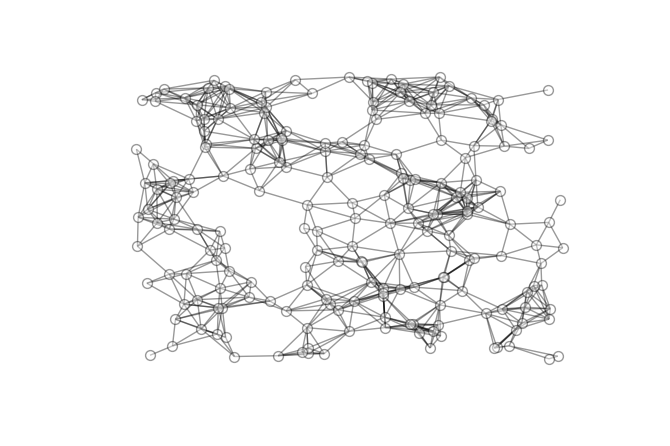

In [6]:
G = nx.random_geometric_graph(200, 0.125)
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_color='w', node_size=50, alpha=0.4)
plt.show()

Change the basic Graph object to a weighted one:

In [7]:
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

edges = [e+(euclidean_distance(pos[e[0]],pos[e[1]]),) for e in G.edges_iter()]
G.add_weighted_edges_from(edges)

Set source node to 13:

In [8]:
dist, path = nx.single_source_dijkstra(G, 13)
print dist[28]
print path[28]

0.78339758282
[13, 198, 105, 2, 144, 171, 184, 159, 28]


*networkx*'s builtin function *single_source_dijkstra* gives the shortest path 13 🡒 198 🡒 105 🡒 2 🡒 144 🡒 171 🡒 184 🡒 159 🡒 28, and path length 0.78339758282, respectively.

In [9]:
path, dist = my_Dijkstra(G, 13)
print dist[28]
print path[28]

0.78339758282
[13, 198, 105, 2, 144, 171, 184, 159, 28]


And my implementation returns the same result.

## Using Min-priority Queue

In our straightforward implementation above, choosing the node with the smallest distance of step 5 needs linear time during each iteration, and in total, it runs in time O($|V|^2$)(where |V| is the number of nodes). To improve its performance, I will store the unvisited nodes in a [min-priority queue](https://en.wikipedia.org/wiki/Min-priority_queue) implemented with a binary heap, and the new implementation is expected to run in time O((|E|+|V|)log|V|)(|E| is the number of edges).

Here's my Python implementation for min-priority queue(see [heapq](https://docs.python.org/2/library/heapq.html)):

In [10]:
import heapq, itertools
from collections import deque

In [11]:
class PriorityQueue():
    
    REMOVED = '<removed-task>'
    
    def __init__(self):
        self.hq = []
        self.entry_finder = {}
        self.counter = itertools.count()
    
    def add_with_priority(self, task, priority):
        'Add a new task or update the priority of an existing task'
        if task in self.entry_finder:
            self.remove_task(task)
        count = next(self.counter)
        entry = [priority, count, task]
        self.entry_finder[task] = entry
        heapq.heappush(self.hq, entry)
    
    def remove_task(self, task):
        'Mark an existing task as REMOVED.  Raise KeyError if not found.'
        entry = self.entry_finder.pop(task)
        entry[-1] = self.REMOVED
    
    def extract_min(self):
        'Remove and return the lowest priority task. Raise KeyError if empty.'
        while self.hq:
            priority, count, task = heapq.heappop(self.hq)
            if task is not self.REMOVED:
                del self.entry_finder[task]
                return task, priority
        raise KeyError('pop from an empty priority queue')

Once you know the concept of priority queue, it's negligible to modified *my_Dijkstra* to the advanced one:

In [12]:
def my_Dijkstra_with_heap(G, s):
    """
    A more efficient implementation for Dijkstra's algorithm using
    min-priority queue.
    
    Parameters
    ----------
    G : NetworkX Graph
    
    s : source node label
    
    Returns
    -------
    path: dict
        Paths from the source.
    dist: dict
        Distances from source node to any other nodes in the graph.
    """
    # Keys are node labels, values are distances from the source to the corresponding
    # nodes, which will be updated during the algorithm.
    dist = {}
    # Keys are node labels, values are previous node in the shortest path from source
    prev = {}
    
    Q = PriorityQueue() # Unvisited nodes
    # Step 1
    Q.add_with_priority(s, 0)
    for v in G:
        dist[v] = float('inf')
    dist[s] = 0
    
    while len(Q.hq):
        try:
            # Step 2, step 5
            # node with the smallest assigned distance will be choosed
            # thanks to min-priority queue, the operation runs in O(1) in this implementation
            # since extract_min remove the lowest priority task from the queue,
            # this operation also implements step 4
            u, dist_u = Q.extract_min()
        except KeyError:
            # Step 5, stop condition
            break
        
        # Step 3
        for v in G[u]:
            alt = dist[u] + G[u][v]['weight']
            if alt < dist[v]:
                dist[v] = alt
                prev[v] = u
                Q.add_with_priority(v, alt)
    
    # Backtrack the shortest path
    path = {}
    for v in dist:
        # Whether the node is reachable from source
        if dist[v] == float('inf'):
            continue
        path[v] = deque([v])
        p = prev.get(v)
        while not p is None:
            path[v].appendleft(p)
            p = prev.get(p)
    
    return path, dist

In [13]:
path, dist = my_Dijkstra_with_heap(G, 13)
print dist[28]
print path[28]

0.78339758282
deque([13, 198, 105, 2, 144, 171, 184, 159, 28])


The correctness is not affected.

In [14]:
def only_run_it(G, func):
    for v in G:
        func(G, v)

In [15]:
for func in [nx.single_source_dijkstra, my_Dijkstra, my_Dijkstra_with_heap]:
    print func.__name__
    %timeit only_run_it(G, func)

single_source_dijkstra
1 loop, best of 3: 400 ms per loop
my_Dijkstra
1 loop, best of 3: 726 ms per loop
my_Dijkstra_with_heap
1 loop, best of 3: 439 ms per loop


But the performance has been improved!